In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, SimpleRNN, Dense, Flatten, RepeatVector, Concatenate, TimeDistributed

# 가상의 데이터 생성
# 데이터의 형태는 실제 데이터셋에 따라 조정되어야 합니다.
num_samples = 1000
max_seq_length = 10
theta = np.random.rand(num_samples, 1) * 2 * np.pi
phi = np.random.rand(num_samples, 1) * 2 * np.pi
sequence = np.random.randint(5, size=(num_samples, max_seq_length))

In [ ]:
# 각각을 독립적인 입력으로 처리
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')
sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

# theta와 phi를 시퀀스의 각 타임스텝에 반복
theta_repeated = RepeatVector(max_seq_length)(theta_input)
phi_repeated = RepeatVector(max_seq_length)(phi_input)

# 시퀀스 임베딩
sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

# 입력들을 합침
concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])

In [ ]:
# RNN 레이어
rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)

# 출력 레이어
output = TimeDistributed(Dense(5, activation='softmax'))(rnn_layer)

# 모델 정의
model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)

# 모델 학습
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1), epochs=10, validation_split=0.2)

# 새로운 theta와 phi 값에 대한 리스트 예측
new_theta = np.array([[0.5]])
new_phi = np.array([[0.5]])
new_sequence = np.zeros((1, max_seq_length))  # 초기 시퀀스는 0으로 설정
predicted_sequence = model.predict({'theta_input': new_theta, 'phi_input': new_phi, 'sequence_input': new_sequence})


In [3]:
print(predicted_sequence)

[[[0.9740461  0.00150249 0.00283895 0.01172099 0.00989156]
  [0.97008383 0.00176454 0.00280468 0.01278157 0.01256536]
  [0.97046465 0.00215553 0.00204273 0.01330278 0.01203432]
  [0.97573686 0.00154915 0.00209132 0.01182453 0.00879812]
  [0.97263134 0.00177073 0.00224956 0.01358771 0.00976066]
  [0.9699743  0.00179466 0.00233559 0.01333149 0.01256401]
  [0.96921283 0.00174713 0.00245519 0.01340958 0.01317524]
  [0.96838456 0.00177329 0.00252713 0.01274544 0.01456957]
  [0.9679192  0.00183257 0.00249692 0.01215918 0.01559203]
  [0.9679409  0.00191405 0.00246025 0.01212933 0.01555538]]]


***

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed

# CSV 파일에서 데이터 읽기
df = pd.read_csv('ByAstar_20230627_093742.csv')

# theta, phi 값 불러오기
theta = df['Theta'].values.reshape(-1, 1)
phi = df['Phi'].values.reshape(-1, 1)

# sequence를 리스트로 변환
sequence = df['combination'].apply(eval).to_list()

# 시퀀스의 최대 길이 계산
max_seq_length = max(len(seq) for seq in sequence)

# 시퀀스를 동일한 길이로 패딩
sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_seq_length)

# 데이터를 훈련 세트와 테스트 세트로 분할
theta_train, theta_test, phi_train, phi_test, sequence_train, sequence_test = train_test_split(theta, phi, sequence_padded, test_size=0.2, random_state=42)

# 입력 레이어 생성
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')
sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

# theta와 phi를 시퀀스의 각 타임스텝에 반복
theta_repeated = RepeatVector(max_seq_length)(theta_input)
phi_repeated = RepeatVector(max_seq_length)(phi_input)

# 시퀀스 임베딩
sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

# 입력들을 합침
concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])

# RNN 레이어
rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)

# 출력 레이어
output = TimeDistributed(Dense(5, activation='softmax'))(rnn_layer)

# 모델 정의
model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)

# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit({'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train}, np.expand_dims(sequence_train, -1), epochs=10, validation_data=({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test}, np.expand_dims(sequence_test, -1)))

# 테스트 세트에 대한 리스트 예측
predicted_sequence = model.predict({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test})

print(predicted_sequence)
# 첫 10개의 예측된 시퀀스 출력
for i in range(10):
    print(f"True sequence: {sequence_test[i]}")
    print(f"Predicted sequence: {np.argmax(predicted_sequence[i], axis=1)}\n")


Epoch 1/10
20/20 [==============================] - 1s 23ms/step - loss: 1.4621 - accuracy: 0.4171 - val_loss: 1.3072 - val_accuracy: 0.5188
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 1.1804 - accuracy: 0.5676 - val_loss: 0.9942 - val_accuracy: 0.6670
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.8385 - accuracy: 0.7400 - val_loss: 0.6518 - val_accuracy: 0.8485
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.5434 - accuracy: 0.8829 - val_loss: 0.4271 - val_accuracy: 0.9168
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.3557 - accuracy: 0.9327 - val_loss: 0.2832 - val_accuracy: 0.9488
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.2422 - accuracy: 0.9606 - val_loss: 0.2018 - val_accuracy: 0.9688
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.1754 - accuracy: 0.9736 - val_loss: 0.1505 - val_accuracy: 0.9756
Epoch 8/10
20/20 [=

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed

# CSV 파일에서 데이터 읽기
df = pd.read_csv('ByAstar_20230627_093742.csv')

# theta, phi 값 불러오기
theta = df['Theta'].values.reshape(-1, 1)
phi = df['Phi'].values.reshape(-1, 1)

# sequence를 리스트로 변환
sequence = df['combination'].apply(eval).to_list()

# 시퀀스의 최대 길이 계산
max_seq_length = max(len(seq) for seq in sequence)

# 시퀀스를 동일한 길이로 패딩
sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_seq_length)

# 데이터를 훈련 세트와 테스트 세트로 분할
theta_train, theta_test, phi_train, phi_test, sequence_train, sequence_test = train_test_split(theta, phi, sequence_padded, test_size=0.2, random_state=42)

# 입력 레이어 생성
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')
sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

# theta와 phi를 시퀀스의 각 타임스텝에 반복
theta_repeated = RepeatVector(max_seq_length)(theta_input)
phi_repeated = RepeatVector(max_seq_length)(phi_input)

# 시퀀스 임베딩
sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

# 입력들을 합침
concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])

# RNN 레이어
rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)

# 출력 레이어
output = TimeDistributed(Dense(5, activation='softmax'))(rnn_layer)

# 모델 정의
model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)

# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit({'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train}, np.expand_dims(sequence_train, -1), epochs=10, validation_data=({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test}, np.expand_dims(sequence_test, -1)))

# 테스트 세트에 대한 리스트 예측
predicted_sequence = model.predict({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test})

# 첫 5개의 예측된 시퀀스 출력
for i in range(5):
    print(f"True sequence: {sequence_test[i]}")
    print(f"Predicted sequence: {np.argmax(predicted_sequence[i], axis=1)}\n")

# 새로운 theta와 phi 값에 대한 리스트 예측
new_theta = np.array([[0.7]])
new_phi = np.array([[1.3]])
new_sequence = np.zeros((1, max_seq_length))  # 초기 시퀀스는 0으로 설정
predicted_sequence = model.predict({'theta_input': new_theta, 'phi_input': new_phi, 'sequence_input': new_sequence})

print(f"Predicted sequence for new theta and phi: {np.argmax(predicted_sequence, axis=-1)}")


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed

# CSV 파일에서 데이터 읽기
df = pd.read_csv('ByAstar_20230627_093742.csv')

# theta, phi 값 불러오기
theta = df['Theta'].values.reshape(-1, 1)
phi = df['Phi'].values.reshape(-1, 1)

# sequence를 리스트로 변환
sequence = df['combination'].apply(eval).to_list()

# 시퀀스의 최대 길이 계산
max_seq_length = max(len(seq) for seq in sequence)

# 시퀀스를 동일한 길이로 패딩
sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_seq_length)

# 데이터를 훈련 세트와 테스트 세트로 분할
theta_train, theta_test, phi_train, phi_test, sequence_train, sequence_test = train_test_split(theta, phi, sequence_padded, test_size=0.2, random_state=42)

# 입력 레이어 생성
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')
sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

# theta와 phi를 시퀀스의 각 타임스텝에 반복
theta_repeated = RepeatVector(max_seq_length)(theta_input)
phi_repeated = RepeatVector(max_seq_length)(phi_input)

# 시퀀스 임베딩
sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

# 입력들을 합침
concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])

# RNN 레이어
rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)

# 출력 레이어
output = TimeDistributed(Dense(5, activation='softmax'))(rnn_layer)

# 모델 정의
model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)

# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit({'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train}, np.expand_dims(sequence_train, -1), epochs=10, validation_data=({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test}, np.expand_dims(sequence_test, -1)))

# 테스트 세트에서 모델 성능 평가
loss, accuracy = model.evaluate({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test}, np.expand_dims(sequence_test, -1))
print(f"Test set accuracy: {accuracy*100:.2f}%")

# 테스트 세트에 대한 리스트 예측
predicted_sequence = model.predict({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test})

# 첫 5개의 예측된 시퀀스 출력
for i in range(5):
    print(f"True sequence: {sequence_test[i]}")
    print(f"Predicted sequence: {np.argmax(predicted_sequence[i], axis=1)}\n")

# 새로운 theta와 phi 값에 대한 리스트 예측
new_theta = np.array([[0.7]])
new_phi = np.array([[1.3]])
new_sequence = np.zeros((1, max_seq_length))  # 초기 시퀀스는 0으로 설정
predicted_sequence = model.predict({'theta_input': new_theta, 'phi_input': new_phi, 'sequence_input': new_sequence})

print(f"Predicted sequence for new theta and phi: {np.argmax(predicted_sequence, axis=-1)}")


Epoch 1/10
20/20 [==============================] - 1s 18ms/step - loss: 1.5131 - accuracy: 0.3521 - val_loss: 1.3328 - val_accuracy: 0.4516
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 1.2311 - accuracy: 0.4855 - val_loss: 1.0895 - val_accuracy: 0.5730
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.9642 - accuracy: 0.6711 - val_loss: 0.7987 - val_accuracy: 0.8166
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.6769 - accuracy: 0.8733 - val_loss: 0.5133 - val_accuracy: 0.9194
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.4145 - accuracy: 0.9353 - val_loss: 0.3128 - val_accuracy: 0.9506
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.2658 - accuracy: 0.9558 - val_loss: 0.2147 - val_accuracy: 0.9627
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.1883 - accuracy: 0.9666 - val_loss: 0.1582 - val_accuracy: 0.9728
Epoch 8/10
20/20 [=

Epoch 1/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0681 - accuracy: 0.9923 - val_loss: 0.0607 - val_accuracy: 0.9925
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0549 - accuracy: 0.9943 - val_loss: 0.0494 - val_accuracy: 0.9943
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0448 - accuracy: 0.9952 - val_loss: 0.0405 - val_accuracy: 0.9958
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0370 - accuracy: 0.9971 - val_loss: 0.0337 - val_accuracy: 0.9985
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9983 - val_loss: 0.0283 - val_accuracy: 0.9987
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0260 - accuracy: 0.9987 - val_loss: 0.0240 - val_accuracy: 0.9987
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0222 - accuracy: 0.9988 - val_loss: 0.0206 - val_accuracy: 0.9991
Epoch 8/10
20/20 [=

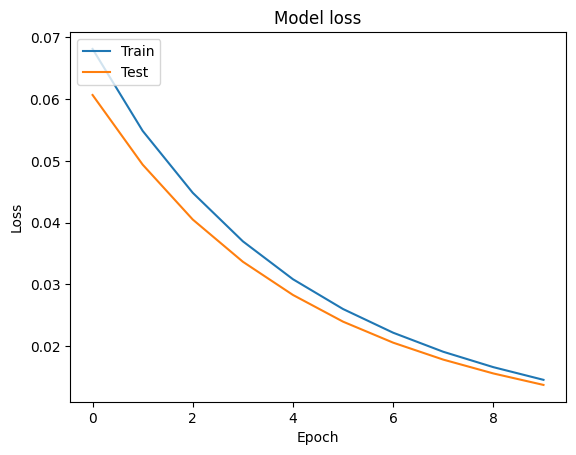

In [16]:
import matplotlib.pyplot as plt

# 모델 학습
history = model.fit({'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train}, np.expand_dims(sequence_train, -1), epochs=10, validation_data=({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test}, np.expand_dims(sequence_test, -1)))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


*** 클래스화

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

class RNNModel:
    def __init__(self, max_seq_length):
        # 모델 구성
        
        # Input : 데이터 Tensor화
        theta_input = Input(shape=(1,), name='theta_input')
        phi_input = Input(shape=(1,), name='phi_input')
        sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

        # RepeatVector : 
        theta_repeated = RepeatVector(max_seq_length)(theta_input)
        phi_repeated = RepeatVector(max_seq_length)(phi_input)
        sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

        concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])
        rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)
        rnn_layer2 = SimpleRNN(64, return_sequences=True)(rnn_layer)
        output = TimeDistributed(Dense(5, activation='softmax'))(rnn_layer2)

        self.model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)
        # plot_model(self.model, show_shapes=True)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    def fit(self, theta, phi, sequence, epochs=50):
        # 데이터셋 분리 train_set 8 : validation_set 2
        sequence_train, sequence_val, theta_train, theta_val, phi_train, phi_val = train_test_split(sequence, theta, phi, test_size=0.2)

        self.history = self.model.fit(
            {'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train},
            np.expand_dims(sequence_train, -1), 
            validation_data=({'theta_input': theta_val, 'phi_input': phi_val, 
                              'sequence_input': sequence_val}, np.expand_dims(sequence_val, -1)), epochs=epochs, batch_size=64)
        # batch 64개로 나누어 50 e

    def plot_history(self):
         # Plot training & validation loss values
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

    def evaluate(self, theta, phi, sequence):
        loss, acc = self.model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
        print("Test Accuracy: {:.2f}".format(acc*100))

In [42]:
# CSV 파일에서 데이터 읽기
df = pd.read_csv('NVspinData_None_-1_230807.csv')

# 데이터셋 분리 - train_set(train) 8 : test_set 2
train_set, test_set = train_test_split(df, shuffle=True, test_size=0.2)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12350 entries, 0 to 12349
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gate length     12350 non-null  int64  
 1   Theta           12350 non-null  float64
 2   Phi             12350 non-null  float64
 3   dt              12350 non-null  float64
 4   combination     12350 non-null  object 
 5   total time      12350 non-null  float64
 6   computing time  12350 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 675.5+ KB


In [43]:
# train_set 데이터 전처리 (train+validation)
theta_tv = train_set['Theta'].values.reshape(-1, 1)
phi_tv = train_set['Phi'].values.reshape(-1, 1)
sequence_tv = train_set['combination'].apply(eval).to_list()
max_seq_length_tv = max(len(seq) for seq in sequence_tv)
sequence_padded_tv = pad_sequences(sequence_tv, maxlen=max_seq_length_tv)

# test_set 데이터 전처리 (final_test)
theta_test = test_set['Theta'].values.reshape(-1, 1)
phi_test = test_set['Phi'].values.reshape(-1, 1)
sequence_test = test_set['combination'].apply(eval).to_list()
max_seq_length_test = max(len(seq) for seq in sequence_test)
sequence_padded_test = pad_sequences(sequence_test, maxlen=max_seq_length_test)

KerasTensor(type_spec=TensorSpec(shape=(None, 35, 1), dtype=tf.float32, name=None), name='repeat_vector_50/Tile:0', description="created by layer 'repeat_vector_50'")
Epoch 1/50
124/124 [==============================] - 3s 12ms/step - loss: 0.6591 - accuracy: 0.8032 - val_loss: 0.1624 - val_accuracy: 0.9571
Epoch 2/50
124/124 [==============================] - 1s 10ms/step - loss: 0.0719 - accuracy: 0.9847 - val_loss: 0.0235 - val_accuracy: 0.9979
Epoch 3/50
124/124 [==============================] - 1s 11ms/step - loss: 0.0130 - accuracy: 0.9994 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 4/50
124/124 [==============================] - 1s 10ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 5/50
124/124 [==============================] - 1s 11ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/50
124/124 [==============================] - 2s 12ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.001

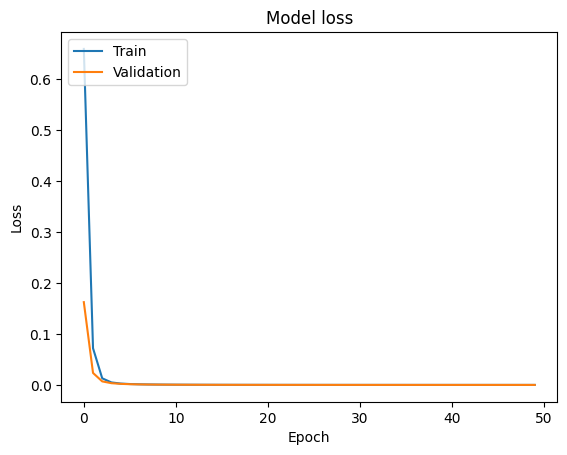

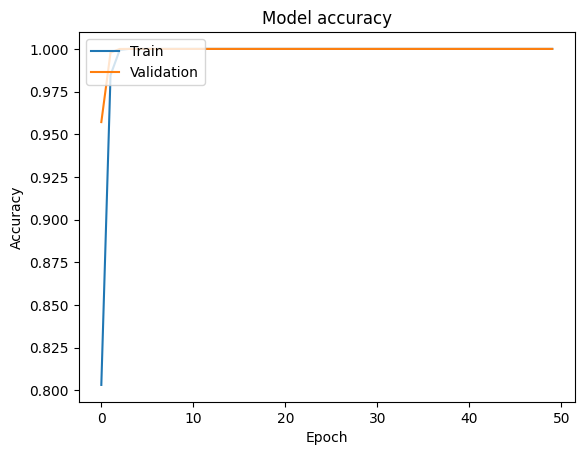

78/78 [==============================] - 0s 4ms/step - loss: 1.1262e-05 - accuracy: 1.0000
Test Accuracy: 100.00


In [44]:
# 모델 초기화
rnn_model = RNNModel(max_seq_length_tv)

# 모델 학습
rnn_model.fit(theta_tv, phi_tv, sequence_padded_tv)

# 결과 그래프 그리기
rnn_model.plot_history()

# 모델 성능 평가
rnn_model.evaluate(theta_test, phi_test, sequence_padded_test)

train set보다 test set의 결과가 더 좋음 ... 수정 필요

***

모델 개선 - L2 정규화, 드롭아웃, 그리고 하이퍼파라미터를 조정하는 방법

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

class RNNModel:
    def __init__(self, max_seq_length):
        # 모델 구성
        theta_input = Input(shape=(1,), name='theta_input')
        phi_input = Input(shape=(1,), name='phi_input')
        sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

        theta_repeated = RepeatVector(max_seq_length)(theta_input)
        phi_repeated = RepeatVector(max_seq_length)(phi_input)
        sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

        concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])
        rnn_layer = SimpleRNN(32, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(concat_layer)
        rnn_layer2 = SimpleRNN(64, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(rnn_layer)
        dropout_layer = Dropout(0.5)(rnn_layer2)
        output = TimeDistributed(Dense(5, activation='softmax'))(dropout_layer)

        self.model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    def fit(self, theta, phi, sequence, epochs=100):
        sequence_train, sequence_val, theta_train, theta_val, phi_train, phi_val = train_test_split(sequence, theta, phi, test_size=0.2)

        self.history = self.model.fit(
            {'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train},
            np.expand_dims(sequence_train, -1), 
            validation_data=({'theta_input': theta_val, 'phi_input': phi_val, 'sequence_input': sequence_val}, np.expand_dims(sequence_val, -1)),
            epochs=epochs, batch_size=64)

    def plot_history(self):
        # Plot training & validation loss values
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def evaluate(self, theta, phi, sequence):
        loss, acc = self.model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
        print("Accuracy: {:.2f}".format(acc*100))

# CSV 파일에서 데이터 읽기
df = pd.read_csv('ByAstar_20230627_093742.csv')
theta = df['Theta'].values.reshape(-1, 1)
phi = df['Phi'].values.reshape(-1, 1)
sequence = df['combination'].apply(eval).to_list()
max_seq_length = max(len(seq) for seq in sequence)
sequence_padded = pad_sequences(sequence, maxlen=max_seq_length)

# 모델 초기화
rnn_model = RNNModel(max_seq_length)

# 모델 학습
rnn_model.fit(theta, phi, sequence_padded)

# 결과 그래프 그리기
rnn_model.plot_history()

# 모델 성능 평가
rnn_model.evaluate(theta, phi, sequence_padded)


***

모델 개선 - 학습률 스케줄링과 다른 옵티마이저를 사용하는 방법

Epoch 1/100
10/10 [==============================] - 2s 56ms/step - loss: 1.3958 - accuracy: 0.5264 - val_loss: 0.3353 - val_accuracy: 0.8869 - lr: 0.0100
Epoch 2/100
10/10 [==============================] - 0s 17ms/step - loss: 0.3101 - accuracy: 0.8972 - val_loss: 0.1005 - val_accuracy: 0.9855 - lr: 0.0100
Epoch 3/100
10/10 [==============================] - 0s 17ms/step - loss: 0.0848 - accuracy: 0.9850 - val_loss: 0.0303 - val_accuracy: 0.9947 - lr: 0.0100
Epoch 4/100
10/10 [==============================] - 0s 17ms/step - loss: 0.0310 - accuracy: 0.9956 - val_loss: 0.0096 - val_accuracy: 0.9985 - lr: 0.0100
Epoch 5/100
10/10 [==============================] - 0s 17ms/step - loss: 0.0121 - accuracy: 0.9991 - val_loss: 0.0037 - val_accuracy: 0.9998 - lr: 0.0100
Epoch 6/100
10/10 [==============================] - 0s 25ms/step - loss: 0.0063 - accuracy: 0.9993 - val_loss: 0.0013 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 7/100
10/10 [==============================] - 0s 29ms/step - lo

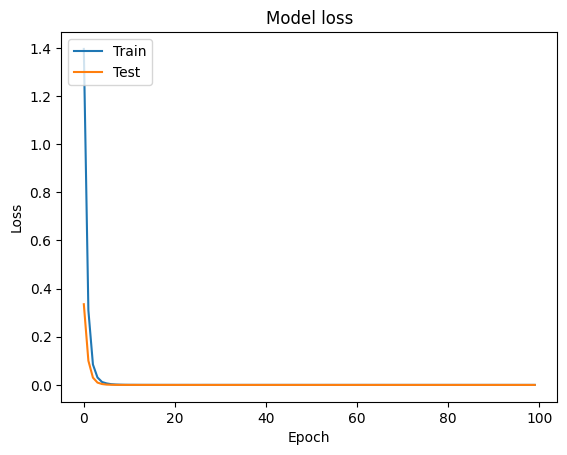

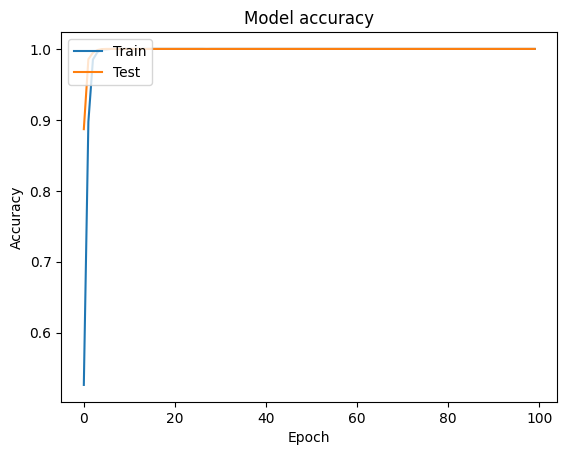

25/25 [==============================] - 0s 5ms/step - loss: 3.4669e-06 - accuracy: 1.0000
Accuracy: 100.00


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

class RNNModel:
    def __init__(self, max_seq_length):
        # 모델 구성
        theta_input = Input(shape=(1,), name='theta_input')
        phi_input = Input(shape=(1,), name='phi_input')
        sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

        theta_repeated = RepeatVector(max_seq_length)(theta_input)
        phi_repeated = RepeatVector(max_seq_length)(phi_input)
        sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

        concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])
        rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)
        rnn_layer2 = SimpleRNN(64, return_sequences=True)(rnn_layer)
        dropout_layer = Dropout(0.5)(rnn_layer2)
        output = TimeDistributed(Dense(5, activation='softmax'))(dropout_layer)

        self.model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

    def fit(self, theta, phi, sequence, epochs=100):
        sequence_train, sequence_val, theta_train, theta_val, phi_train, phi_val = train_test_split(sequence, theta, phi, test_size=0.2)

        def lr_schedule(epoch):
            return 0.01 * np.power(0.5, epoch // 10)

        self.history = self.model.fit(
            {'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train},
            np.expand_dims(sequence_train, -1), 
            validation_data=({'theta_input': theta_val, 'phi_input': phi_val, 'sequence_input': sequence_val}, np.expand_dims(sequence_val, -1)),
            epochs=epochs, batch_size=64, callbacks=[LearningRateScheduler(lr_schedule)])

    def plot_history(self):
        # Plot training & validation loss values
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def evaluate(self, theta, phi, sequence):
        loss, acc = self.model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
        print("Accuracy: {:.2f}".format(acc*100))

# CSV 파일에서 데이터 읽기
df = pd.read_csv('ByAstar_20230627_093742.csv')
theta = df['Theta'].values.reshape(-1, 1)
phi = df['Phi'].values.reshape(-1, 1)
sequence = df['combination'].apply(eval).to_list()
max_seq_length = max(len(seq) for seq in sequence)
sequence_padded = pad_sequences(sequence, maxlen=max_seq_length)

# 모델 초기화
rnn_model = RNNModel(max_seq_length)

# 모델 학습
rnn_model.fit(theta, phi, sequence_padded)

# 결과 그래프 그리기
rnn_model.plot_history()

# 모델 성능 평가
rnn_model.evaluate(theta, phi, sequence_padded)


***

LSTM

Epoch 1/10
10/10 [==============================] - 7s 190ms/step - loss: 1.5532 - accuracy: 0.3967 - val_loss: 1.4815 - val_accuracy: 0.4887
Epoch 2/10
10/10 [==============================] - 0s 24ms/step - loss: 1.4283 - accuracy: 0.4953 - val_loss: 1.3798 - val_accuracy: 0.4889
Epoch 3/10
10/10 [==============================] - 0s 24ms/step - loss: 1.3319 - accuracy: 0.5060 - val_loss: 1.2624 - val_accuracy: 0.5238
Epoch 4/10
10/10 [==============================] - 0s 23ms/step - loss: 1.2101 - accuracy: 0.5561 - val_loss: 1.1223 - val_accuracy: 0.5965
Epoch 5/10
10/10 [==============================] - 0s 24ms/step - loss: 1.0784 - accuracy: 0.6177 - val_loss: 1.0009 - val_accuracy: 0.6468
Epoch 6/10
10/10 [==============================] - 0s 27ms/step - loss: 0.9634 - accuracy: 0.6563 - val_loss: 0.9030 - val_accuracy: 0.6624
Epoch 7/10
10/10 [==============================] - 0s 22ms/step - loss: 0.8742 - accuracy: 0.6913 - val_loss: 0.8356 - val_accuracy: 0.7468
Epoch 8/10
1

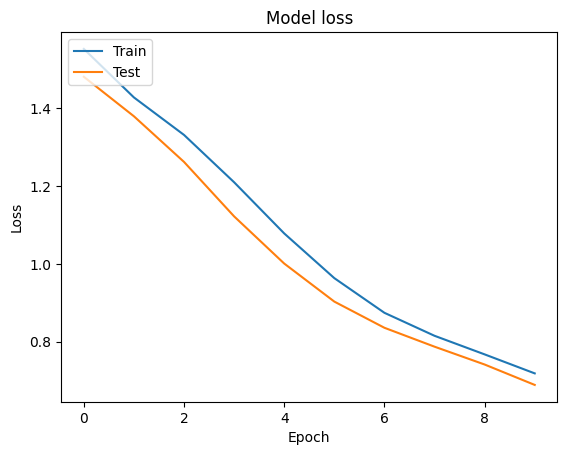

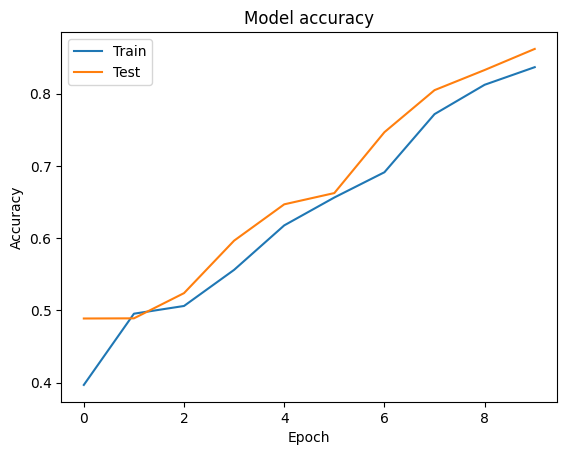

5/5 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.8621
Train Accuracy: 85.46%
Test Accuracy: 86.21%


In [2]:
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

class SequencePredictor:
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.df['combination'] = self.df['combination'].apply(ast.literal_eval)
        self.theta = self.df['Theta'].values.reshape(-1, 1)
        self.phi = self.df['Phi'].values.reshape(-1, 1)
        self.sequence = self.df['combination'].tolist()
        self.max_seq_length = max(len(seq) for seq in self.sequence)
        self.sequence_padded = pad_sequences(self.sequence, maxlen=self.max_seq_length)
        self.theta_train, self.theta_test, self.phi_train, self.phi_test, self.sequence_train, self.sequence_test = \
            train_test_split(self.theta, self.phi, self.sequence_padded, test_size=0.2, random_state=42)

    def create_model(self):
        theta_input = Input(shape=(1,), name='theta_input')
        phi_input = Input(shape=(1,), name='phi_input')
        sequence_input = Input(shape=(self.max_seq_length,), name='sequence_input')
        theta_repeated = RepeatVector(self.max_seq_length)(theta_input)
        phi_repeated = RepeatVector(self.max_seq_length)(phi_input)
        sequence_embedding = Embedding(5, 32, input_length=self.max_seq_length)(sequence_input)
        concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])
        lstm_layer = LSTM(32, return_sequences=True)(concat_layer)
        output = TimeDistributed(Dense(5, activation='softmax'))(lstm_layer)
        self.model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    def train_model(self, epochs=10, batch_size=64):
        self.history = self.model.fit(
            {'theta_input': self.theta_train, 'phi_input': self.phi_train, 'sequence_input': self.sequence_train},
            np.expand_dims(self.sequence_train, -1), 
            validation_data=({'theta_input': self.theta_test, 'phi_input': self.phi_test, 'sequence_input': self.sequence_test}, np.expand_dims(self.sequence_test, -1)),
            epochs=epochs, batch_size=batch_size
        )

    def plot_graphs(self):
        # 손실 그래프
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # 정확도 그래프
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def evaluate_model(self):
        # 모델 성능 평가
        train_loss, train_acc = self.model.evaluate({'theta_input': self.theta_train, 'phi_input': self.phi_train, 'sequence_input': self.sequence_train}, np.expand_dims(self.sequence_train, -1))
        test_loss, test_acc = self.model.evaluate({'theta_input': self.theta_test, 'phi_input': self.phi_test, 'sequence_input': self.sequence_test}, np.expand_dims(self.sequence_test, -1))
        print(f"Train Accuracy: {train_acc*100:.2f}%")
        print(f"Test Accuracy: {test_acc*100:.2f}%")

# 사용법
predictor = SequencePredictor('ByAstar_20230627_093742.csv')
predictor.create_model()
predictor.train_model(epochs=10, batch_size=64)
predictor.plot_graphs()
predictor.evaluate_model()

필요한 라이브러리를 불러옵니다.

numpy와 pandas는 데이터 처리와 변환에 사용됩니다.
ast는 문자열 형태로 저장된 리스트를 파이썬 리스트로 변환하는 데 사용됩니다.
train_test_split은 데이터를 학습 데이터와 테스트 데이터로 분리하는 데 사용됩니다.
Model, Input, LSTM, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed는 모델을 구성하는 데 사용되는 Keras의 함수 및 클래스입니다.
pad_sequences는 모든 시퀀스의 길이를 동일하게 맞추는 데 사용됩니다.
Adam은 최적화 알고리즘을 설정하는 데 사용됩니다.
matplotlib.pyplot은 학습 과정에서의 손실과 정확도를 그래프로 표시하는 데 사용됩니다.
SequencePredictor 클래스를 정의합니다.

이 클래스는 CSV 파일에서 데이터를 불러오고, 모델을 생성하고, 모델을 학습하고, 학습 과정을 그래프로 표시하고, 모델을 평가하는 기능을 제공합니다.
__init__ 메소드를 정의합니다.

이 메소드는 SequencePredictor 객체를 생성할 때 호출됩니다.
CSV 파일에서 데이터를 불러오고, 문자열 형태의 시퀀스를 리스트로 변환하고, 데이터를 학습 데이터와 테스트 데이터로 분리하는 작업을 수행합니다.
create_model 메소드를 정의합니다.

이 메소드는 LSTM 기반의 RNN 모델을 생성합니다.
모델은 theta, phi, 시퀀스를 입력으로 받고, 시퀀스를 출력합니다.
train_model 메소드를 정의합니다.

이 메소드는 모델을 학습 데이터로 학습시킵니다.
학습 과정에서의 손실과 정확도는 history 객체에 저장됩니다.
plot_graphs 메소드를 정의합니다.

이 메소드는 학습 과정에서의 손실과 정확도를 그래프로 표시합니다.
evaluate_model 메소드를 정의합니다.

이 메소드는 모델을 학습 데이터와 테스트 데이터에서 평가하고, 정확도를 출력합니다.
SequencePredictor 객체를 생성하고, 모델을 생성하고, 모델을 학습하고, 학습 과정을 그래프로 표시하고, 모델을 평가하는 코드를 실행합니다.

***

GRU

Epoch 1/10
10/10 [==============================] - 3s 61ms/step - loss: 1.5159 - accuracy: 0.4495 - val_loss: 1.4558 - val_accuracy: 0.4904
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 1.4038 - accuracy: 0.5036 - val_loss: 1.3585 - val_accuracy: 0.5155
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 1.3121 - accuracy: 0.5247 - val_loss: 1.2539 - val_accuracy: 0.5361
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 1.2008 - accuracy: 0.5458 - val_loss: 1.1205 - val_accuracy: 0.5588
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 1.0563 - accuracy: 0.5798 - val_loss: 0.9567 - val_accuracy: 0.6220
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.8938 - accuracy: 0.6753 - val_loss: 0.8037 - val_accuracy: 0.7389
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.7650 - accuracy: 0.7965 - val_loss: 0.7080 - val_accuracy: 0.9025
Epoch 8/10
10

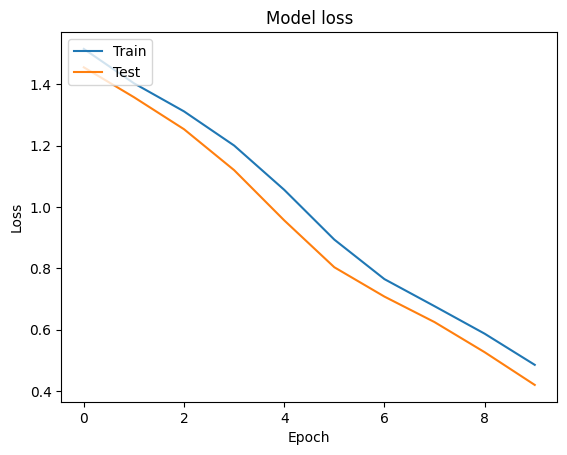

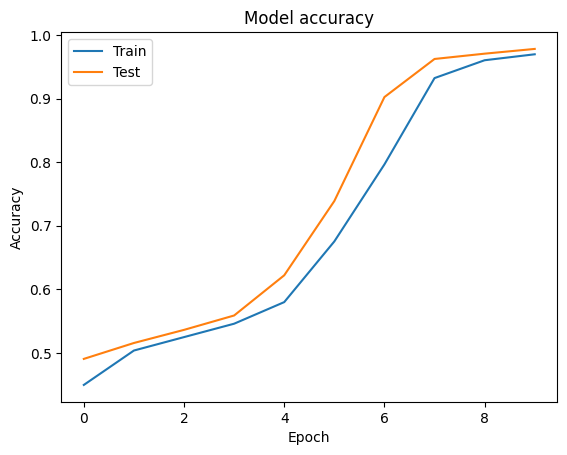

5/5 [==============================] - 0s 4ms/step - loss: 0.4199 - accuracy: 0.9783
Train Accuracy: 97.39%
Test Accuracy: 97.83%


In [3]:
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

class SequencePredictor:
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.df['combination'] = self.df['combination'].apply(ast.literal_eval)
        self.theta = self.df['Theta'].values.reshape(-1, 1)
        self.phi = self.df['Phi'].values.reshape(-1, 1)
        self.sequence = self.df['combination'].tolist()
        self.max_seq_length = max(len(seq) for seq in self.sequence)
        self.sequence_padded = pad_sequences(self.sequence, maxlen=self.max_seq_length)
        self.theta_train, self.theta_test, self.phi_train, self.phi_test, self.sequence_train, self.sequence_test = \
            train_test_split(self.theta, self.phi, self.sequence_padded, test_size=0.2, random_state=42)

    def create_model(self):
        theta_input = Input(shape=(1,), name='theta_input')
        phi_input = Input(shape=(1,), name='phi_input')
        sequence_input = Input(shape=(self.max_seq_length,), name='sequence_input')
        theta_repeated = RepeatVector(self.max_seq_length)(theta_input)
        phi_repeated = RepeatVector(self.max_seq_length)(phi_input)
        sequence_embedding = Embedding(5, 32, input_length=self.max_seq_length)(sequence_input)
        concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])
        gru_layer = GRU(32, return_sequences=True)(concat_layer)
        output = TimeDistributed(Dense(5, activation='softmax'))(gru_layer)
        self.model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    def train_model(self, epochs=10, batch_size=64):
        self.history = self.model.fit(
            {'theta_input': self.theta_train, 'phi_input': self.phi_train, 'sequence_input': self.sequence_train},
            np.expand_dims(self.sequence_train, -1), 
            validation_data=({'theta_input': self.theta_test, 'phi_input': self.phi_test, 'sequence_input': self.sequence_test}, np.expand_dims(self.sequence_test, -1)),
            epochs=epochs, batch_size=batch_size
        )

    def plot_graphs(self):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def evaluate_model(self):
        train_loss, train_acc = self.model.evaluate({'theta_input': self.theta_train, 'phi_input': self.phi_train, 'sequence_input': self.sequence_train}, np.expand_dims(self.sequence_train, -1))
        test_loss, test_acc = self.model.evaluate({'theta_input': self.theta_test, 'phi_input': self.phi_test, 'sequence_input': self.sequence_test}, np.expand_dims(self.sequence_test, -1))
        print(f"Train Accuracy: {train_acc*100:.2f}%")
        print(f"Test Accuracy: {test_acc*100:.2f}%")

predictor = SequencePredictor('ByAstar_20230627_093742.csv')
predictor.create_model()
predictor.train_model(epochs=10, batch_size=64)
predictor.plot_graphs()
predictor.evaluate_model()

LSTM 대신 GRU를 사용하는 주요 이유 중 하나는 계산 비용을 줄이기 위함입니다. LSTM은 입력, 출력, 그리고 망각 게이트를 가지고 있는 반면, GRU는 업데이트 게이트와 리셋 게이트 두 가지만 가지고 있어 연산 비용이 줄어듭니다. 이는 특히 큰 데이터셋에서 유용할 수 있습니다. 

필요한 라이브러리를 불러옵니다.

numpy와 pandas는 데이터 처리와 변환에 사용됩니다.
ast는 문자열 형태로 저장된 리스트를 파이썬 리스트로 변환하는 데 사용됩니다.
train_test_split은 데이터를 학습 데이터와 테스트 데이터로 분리하는 데 사용됩니다.
Model, Input, GRU, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed는 모델을 구성하는 데 사용되는 Keras의 함수 및 클래스입니다.
pad_sequences는 모든 시퀀스의 길이를 동일하게 맞추는 데 사용됩니다.
Adam은 최적화 알고리즘을 설정하는 데 사용됩니다.
matplotlib.pyplot은 학습 과정에서의 손실과 정확도를 그래프로 표시하는 데 사용됩니다.
SequencePredictor 클래스를 정의합니다.

이 클래스는 CSV 파일에서 데이터를 불러오고, 모델을 생성하고, 모델을 학습하고, 학습 과정을 그래프로 표시하고, 모델을 평가하는 기능을 제공합니다.
__init__ 메소드를 정의합니다.

이 메소드는 SequencePredictor 객체를 생성할 때 호출됩니다.
CSV 파일에서 데이터를 불러오고, 문자열 형태의 시퀀스를 리스트로 변환하고, 데이터를 학습 데이터와 테스트 데이터로 분리하는 작업을 수행합니다.
create_model 메소드를 정의합니다.

이 메소드는 GRU 기반의 RNN 모델을 생성합니다.
모델은 theta, phi, 시퀀스를 입력으로 받고, 시퀀스를 출력합니다.
train_model 메소드를 정의합니다.

이 메소드는 모델을 학습 데이터로 학습시킵니다.
학습 과정에서의 손실과 정확도는 history 객체에 저장됩니다.
plot_graphs 메소드를 정의합니다.

이 메소드는 학습 과정에서의 손실과 정확도를 그래프로 표시합니다.
evaluate_model 메소드를 정의합니다.

이 메소드는 모델을 학습 데이터와 테스트 데이터에서 평가하고, 정확도를 출력합니다.
SequencePredictor 객체를 생성하고, 모델을 생성하고, 모델을 학습하고, 학습 과정을 그래프로 표시하고, 모델을 평가하는 코드를 실행합니다.

***